In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os,sys,glob,random, re, copy, time, itertools
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import toml
sns.set_theme()
sns.set()

# from load_data import load_robot_data, load_fish_data, load_behavior_data
from extend_robot_data import extend_robot_data
from plot import plot_all_positions, plot_runs, circular_hist, plot_starts_ends, plot_rotations_and_heatmap, plot_inter_individual_distances, plot_run_length_hist, plot_robot_distance_goal, plot_runlength_dist_goal_target_corr
from plot_usage_statistics import plot_weekday_business, plot_daily_number_runs, plot_time_of_day_histogram, plot_daily_use_times_and_operational_times, plot_daily_start_end_times
from util import filter_dates_dict_for_challenge_runs, flatten_2d_list, get_fish_following_per_run, distance, get_fish_pos_per_run, get_challenge_runs, get_successful_runs, get_distance_to_goal, save_dates_to_npz, load_dates_from_npz, get_hours_minutes_seconds_from_decimal_hours, calculate_run_velocity_speed_acceleration
from iterator_functions import iteratively_evaluate_dates

from load_data import load_robot_data, load_behavior_data, load_fish_data
from clean_data import clean_data
    
# from importlib import reload  
# reload(load_robot_data)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [7]:
# specify start and end date (min: 2021-11-19 ; max: 2022-10-25)
start_date = "2022-09-01"
end_date = "2022-10-01"

#### load already parsed files

In [9]:
dates_dict = None
dates_dict = load_dates_from_npz(start_date, end_date, only_challenges=True)

Loading data from npz files.....
Loading 2022-09-01
Loading 2022-09-02
Loading 2022-09-03
Loading 2022-09-04
Loading 2022-09-05
Loading 2022-09-07
Loading 2022-09-08
Loading 2022-09-09
Loading 2022-09-10
Loading 2022-09-11
Loading 2022-09-12
Loading 2022-09-14
Loading 2022-09-15
Loading 2022-09-16
Loading 2022-09-17
Loading 2022-09-18
Loading 2022-09-19
Loading 2022-09-20
Loading 2022-09-21
Loading 2022-09-22
Loading 2022-09-23
Loading 2022-09-24
Loading 2022-09-25
Loading 2022-09-26
Loading 2022-09-28
Loading 2022-09-29
Loading 2022-09-30
Loading 2022-10-01
Loading done!


#### parse form logs

In [ ]:
debug=True

# parse fom logs

# directories
base_dir="E:/tubCloud/HF_logs/"
# base_dir="C:/Users/admin/repos/thesis/logs_16_03_22/"

fish_dir=(base_dir+"fish")
robot_dir=(base_dir+"robot")

behavior_dir=(base_dir+"behavior_prints")
user_input_dir=(base_dir+"user_input")

# Load robot data
dates_dict_robot = load_robot_data(robot_dir, start_date, end_date)

dates_dict_robot[end_date].keys()
dates_dict = copy.deepcopy(dates_dict_robot)

# load behavior print data
dates_dict = load_behavior_data(behavior_dir, dates_dict, start_date, end_date)

# load fish data
dates_dict = load_fish_data(fish_dir, dates_dict, start_date, end_date)

# clean data: check if number of fish stay the same in challenge runs and check if target fish starts in correct pos
dates_dict = clean_data(dates_dict, debug=debug)

print(f"\nDone!")

### Extend data

In [16]:
# Extend robot data
dates_dict = extend_robot_data(dates_dict)

2022-09-01: Mean run length: 39.59; median run length: 26.55
2022-09-02: Mean run length: 37.54; median run length: 25.72
2022-09-03: Mean run length: 41.98; median run length: 32.31
2022-09-04: Mean run length: 40.27; median run length: 26.89
2022-09-05: Mean run length: 45.30; median run length: 32.89
2022-09-07: Mean run length: 29.99; median run length: 19.48
2022-09-08: Mean run length: 41.39; median run length: 25.89
2022-09-09: Mean run length: 42.91; median run length: 29.32
2022-09-10: Mean run length: 37.51; median run length: 26.52
2022-09-11: Mean run length: 39.44; median run length: 23.79
2022-09-12: Mean run length: 43.78; median run length: 24.42
2022-09-14: Mean run length: 40.17; median run length: 26.80
2022-09-15: Mean run length: 39.81; median run length: 23.78
2022-09-16: Mean run length: 44.24; median run length: 24.75
2022-09-17: Mean run length: 41.40; median run length: 27.05
2022-09-18: Mean run length: 42.20; median run length: 25.93
2022-09-19: Mean run len

### sanity checks

In [ ]:
# challenges and runs same length


In [ ]:
# detect position jumps (= high acceleration)
dates_keys = dates_dict.keys()

for date_key in dates_keys:    
    date_dict = dates_dict[date_key]
    
    runs = date_dict["runs"]
    for id_run, run in enumerate(runs):
        run_accelerations = date_dict["accelerations"][id_run]
        # plt.plot(run_accelerations)
        # plt.show()

        # find accerations over 200
        ids_over_accelerations = np.where(np.abs(run_accelerations) > 200)

In [ ]:
# detect rotation jumps


In [ ]:
# print(dates_dict['2022-02-02']["runs"])
test = {'timestamps': dates_dict['2022-02-02']['timestamps'], 'positions': dates_dict['2022-02-02']['positions'], 'fish': dates_dict['2022-02-02']['fish']}
pd.DataFrame.from_dict(test).head(100)

In [ ]:
### check for id skips in run timestamps
for date_key in dates_dict.keys():
    date_dict = dates_dict[date_key]
    date_dict_runs = date_dict["runs"]
    date_dict_ts = date_dict["timestamps"]
    
    start_pointer = 0
    for id_run, run in enumerate(date_dict_runs):
        if start_pointer != run[0]:
            print(f"timestamps skipped in run {run}: prev-run: {date_dict_runs[id_run-1]}, end last +1: {date_dict_ts[start_pointer]}; run start:{date_dict_ts[run[0]]}")
            print(f"\t{start_pointer - run[0]}")
        start_pointer = run[1]+1

In [ ]:
### challenge runs cannot be longer than ~180 seconds
for date_key in dates_dict.keys():
    date_dict = dates_dict[date_key]
    date_dict_runs = date_dict["runs"]
    
    if len(date_dict_runs) > 0:
        # set non challenge runs to zero length for this check
        date_run_lengths_masked = np.ma.array(date_dict["run_lengths"], mask=np.invert(date_dict["challenges"]), copy=True, fill_value=0)
        date_run_lengths_zerofilled = np.ma.filled(date_run_lengths_masked)
        # print(date_run_lengths_zerofilled)
        # date_c_run_lengths = np.array(date_dict["run_lengths"])[date_dict["challenges"]]
        # print(date_c_run_lengths)
        long_c_runs = np.where(date_run_lengths_zerofilled > 185)[0]

        # manage too long runs
        if len(long_c_runs) > 0:
            print(date_run_lengths_zerofilled[long_c_runs])
            print(long_c_runs)
            for long_run in long_c_runs:
                long_run_start = date_dict["timestamps"][date_dict_runs[long_run][0]]
                long_run_end = date_dict["timestamps"][date_dict_runs[long_run][1]]
                print(f"long run at: {long_run_start} : {long_run_end}")


***
# Find turns

In [ ]:
from analyze_data import get_run_turns

%matplotlib inline
only_successful = True

all_turning_points = []
all_dist_at_turning_points = []

for date_key in dates_dict:
    date_dict = dates_dict[date_key]
    fish_instance = date_dict["fish"]
    runs = date_dict["runs"]
    # filter runs
    if only_successful:
        runs, ids_runs = get_successful_runs(runs,date_dict["successful"])
    elif challenges:
        runs, ids_runs = get_challenge_runs(runs,date_dict["challenges"])
    else:
        runs = date_dict["runs"]
        ids_runs = list(range(len(runs)))
        
    # get pos for all fish for all timesteps
    if len(runs) > 0:
        fish_pos_runs = get_fish_pos_per_run(fish_instance,runs)
    else:
        print(f"No runs in {date_key}")
        continue    
    
    
    turning_points_date = []
    dist_at_turning_points_date = []
    # iterate runs
    for id_run, run in enumerate(runs):
        # get data
        all_fish_pos_this_run = fish_pos_runs[id_run]
        fish1_pos_this_run = np.array([fish[0] for fish in all_fish_pos_this_run])
        robot_pos_run = np.array(date_dict['positions'][run[0]:run[1]+1])
        robot_dir_run = np.array(date_dict['orientation'][run[0]:run[1]+1])

        turning_points, dists_at_turning_points = get_run_turns(all_fish_pos_this_run, fish1_pos_this_run, robot_pos_run, robot_dir_run,plot=True)
        turning_points_date.extend(turning_points)
        dist_at_turning_points_date.extend(dists_at_turning_points)
        #print(turning_points)
    #print(turning_points_date)
    #print(dist_at_turning_points_date)
    all_turning_points.extend(turning_points_date)
    all_dist_at_turning_points.extend(dist_at_turning_points_date)
    
fig = plt.figure(figsize=(16,9))
plt.hist(all_dist_at_turning_points, bins=20)

# Stats page

In [35]:
def evaluate_day_stats(date_dict):
    num_loaded_days = 0
    num_runs = 0
    num_ch_runs = 0
    num_succ_runs = 0
    use_time_h = 0
    est_visitors = 0
    
    if date_dict:
        num_loaded_days = 1
        num_runs = len(date_dict["runs"])
        num_ch_runs = len(np.flatnonzero(date_dict["challenges"]))
        num_succ_runs = len(np.flatnonzero(date_dict["successful"]))
        use_time_h = np.sum(date_dict["run_lengths"])/60/60
        est_visitors = len(date_dict['runs']) - len(np.flatnonzero(date_dict["challenges"]))
    
    return [num_loaded_days, num_runs, num_ch_runs, num_succ_runs, use_time_h, est_visitors]

start_date = "2021-11-19"
end_date = "2021-11-25"
stats = np.array(iteratively_evaluate_dates(start_date, end_date, eval_date_function=evalaute_day_stats, load_only_challenge_data=False, verbose=False))

print(f"Total number of days: {(datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days}")
print(f"Total number of active days: {np.sum(stats[:,0])}")
print(f"Total number of runs: {np.sum(stats[:,1])}")
print(f"Total number of challenge runs: {np.sum(stats[:,2])}")
print(f"Total number of successful runs: {np.sum(stats[:,3])}")
print(f"Total use time: {np.sum(stats[:,4])} h")
print(f"Total number of estimated visitors: {np.sum(stats[:,5])}")

Loading data from npz files.....
Loading 2021-11-19
Loading done!
2021-11-19: Mean run length: 44.49; median run length: 28.19
2021-11-19: Number of challenge runs:99, successful:76 | 76.77% successful runs
Done
Loading data from npz files.....
Loading 2021-11-20
Loading done!
2021-11-20: Mean run length: 37.60; median run length: 24.77
2021-11-20: Number of challenge runs:145, successful:125 | 86.21% successful runs
Done
Loading data from npz files.....
Loading 2021-11-21
Loading done!
2021-11-21: Mean run length: 33.78; median run length: 19.76
2021-11-21: Number of challenge runs:169, successful:136 | 80.47% successful runs
Done
Loading data from npz files.....
Loading 2021-11-22
Loading done!
2021-11-22: Mean run length: 42.85; median run length: 25.33
2021-11-22: Number of challenge runs:52, successful:40 | 76.92% successful runs
Done
Loading data from npz files.....
Loading 2021-11-23
Loading done!
2021-11-23: Mean run length: 144.62; median run length: 19.12
2021-11-23: Number o

***
# Plot

### Plot robot positions **

In [ ]:
%matplotlib inline
# plot all positions
plot_all_positions(dates_dict, start_date=start_date, end_date=end_date, challenges=True, only_successful=True)

### Plot average rotation and position heatmap **

In [ ]:
# plot average rotation and position heatmap
%matplotlib inline
plot_rotations_and_heatmap(dates_dict, start_date=start_date, end_date=end_date, challenges=True, only_successful=True, ignore_robot_standing=True, polar_density=True)

### Plot individual runs **

In [ ]:
# plot (challenge) runs
plot_runs(dates_dict, start_date="2022-02-10", end_date="2022-02-10", challenges=True, only_successful=True)

### Plot start and end points of runs **

In [ ]:
# plot start and end points for all (challenge) runs
plot_starts_ends(dates_dict, start_date=None, end_date=None, challenges=True, only_successful=True)

### Plot run length histogram **

In [ ]:
# plot run length histogram
plot_run_length_hist(dates_dict, start_date=start_date, end_date=None, bin_size=5, challenges=True, only_successful=True)

### Plot inter-individual distances between robot and target fish for all (challenge) runs **

In [ ]:
# plot inter-individual distances between robot and target fish for all (challenge) runs
plot_inter_individual_distances(dates_dict, start_date, end_date, challenges=True, only_successful=True, bins=10)

### Plot robot distance to goal over time **

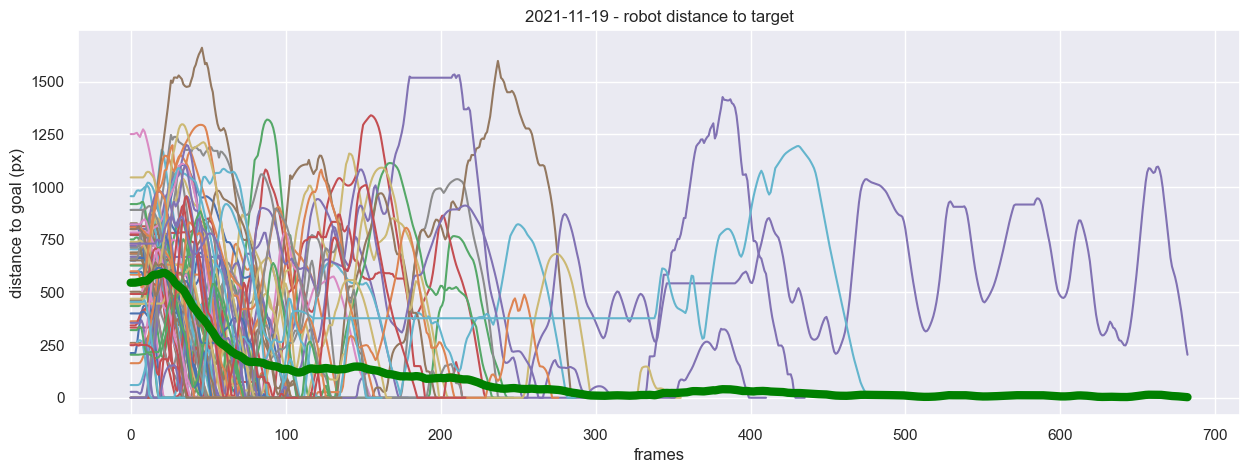

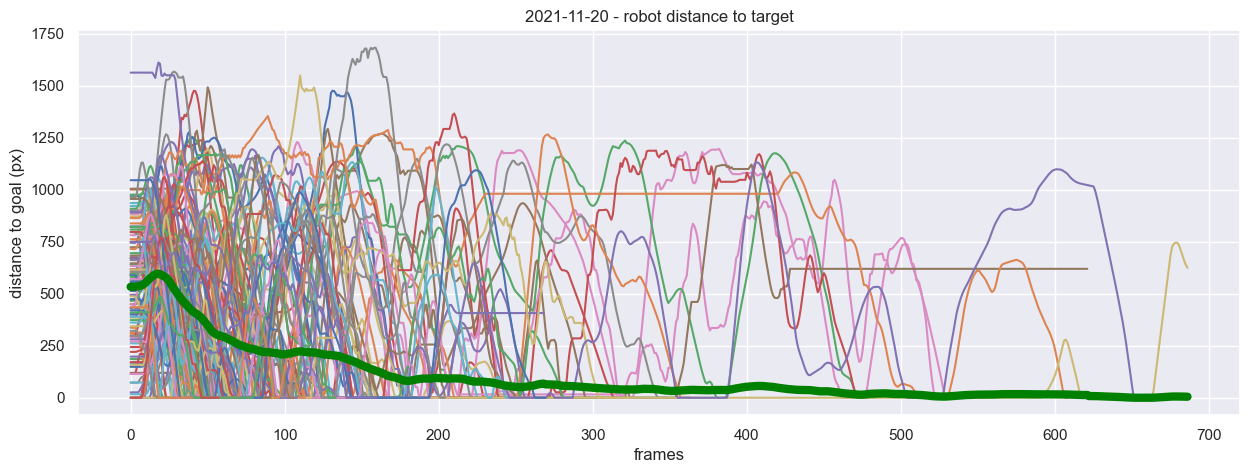

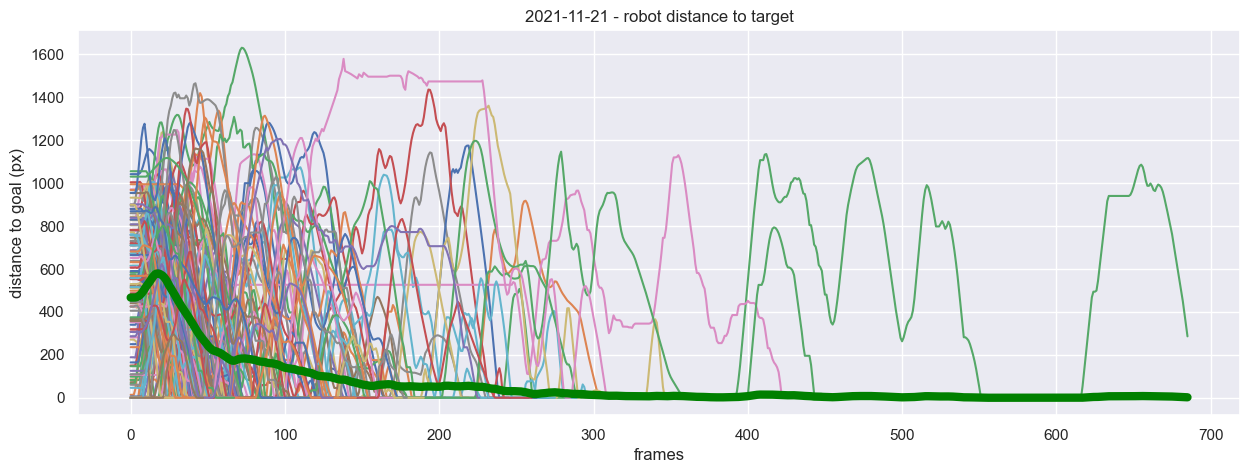

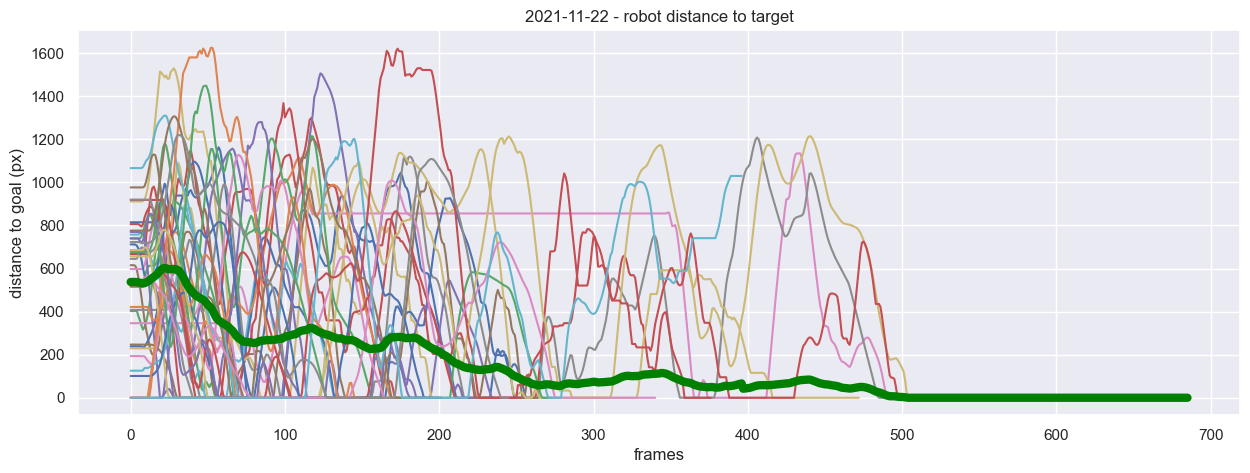

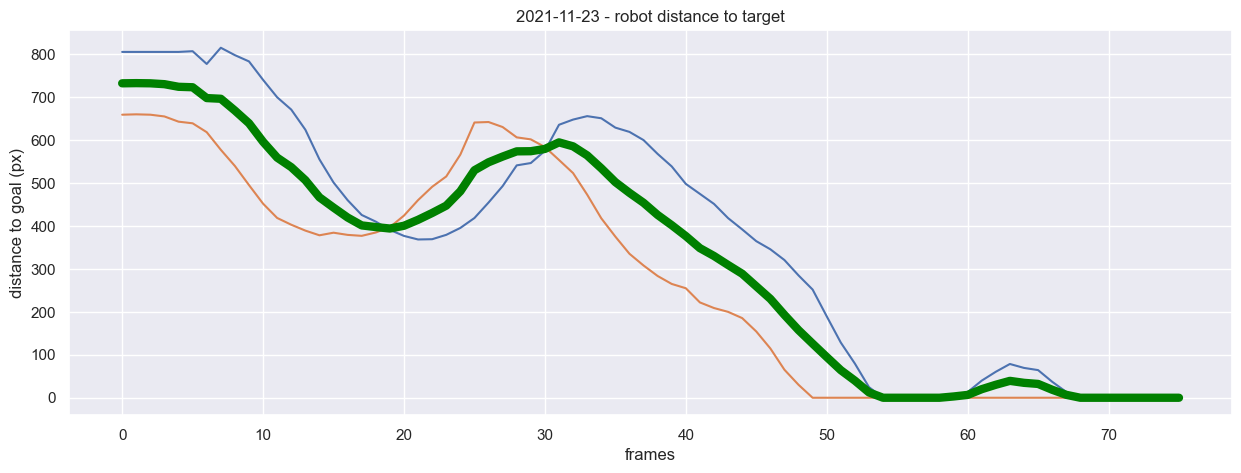

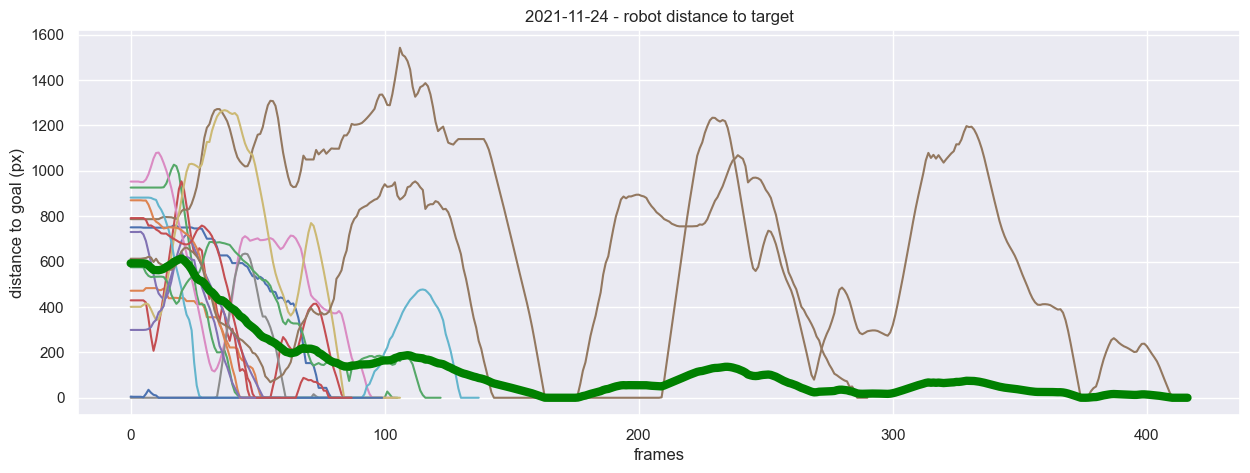

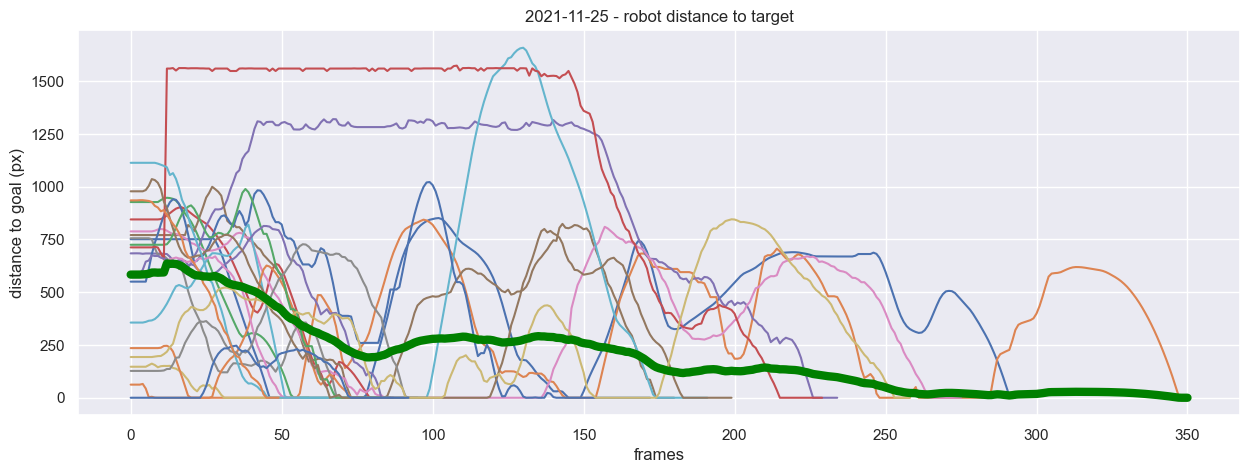

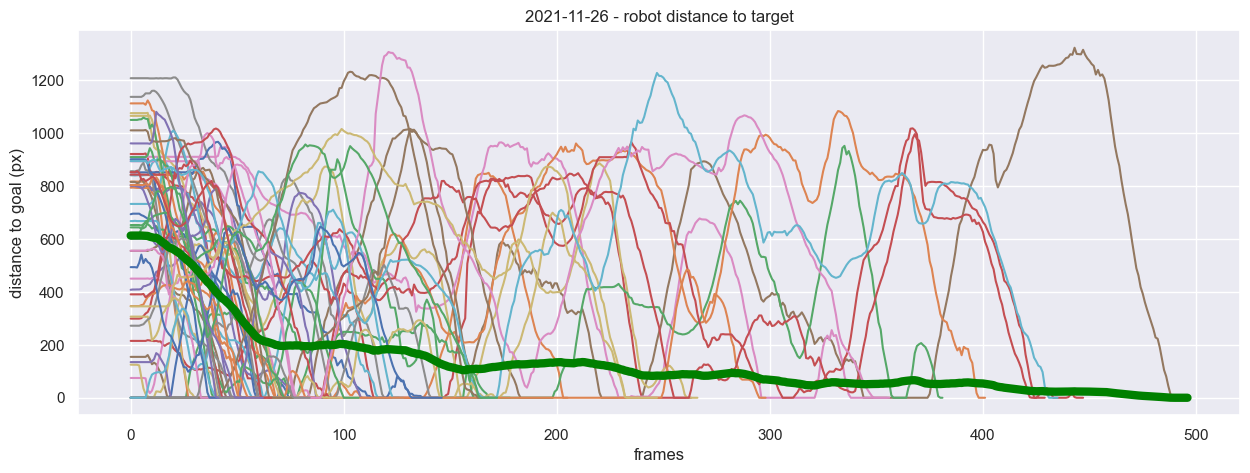

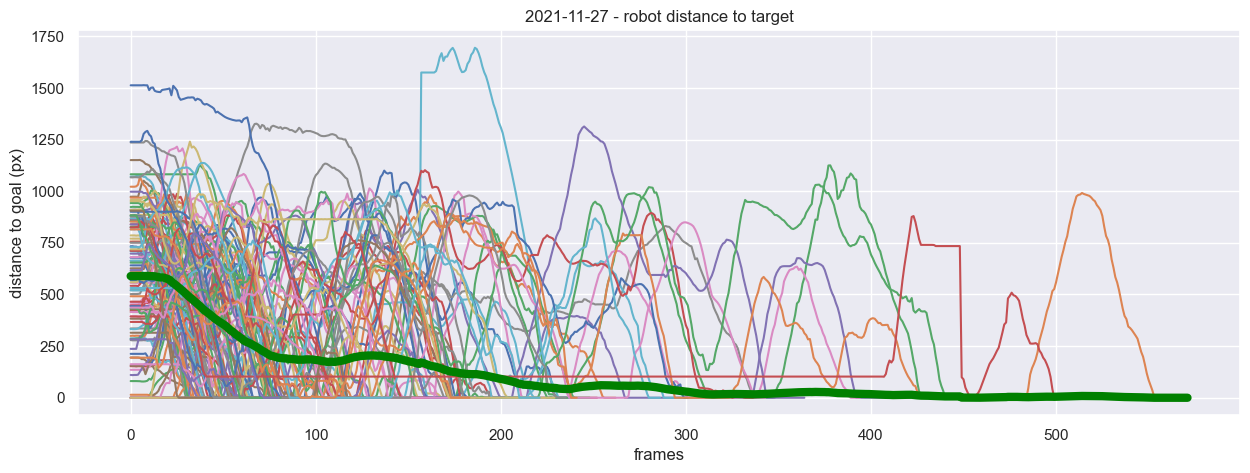

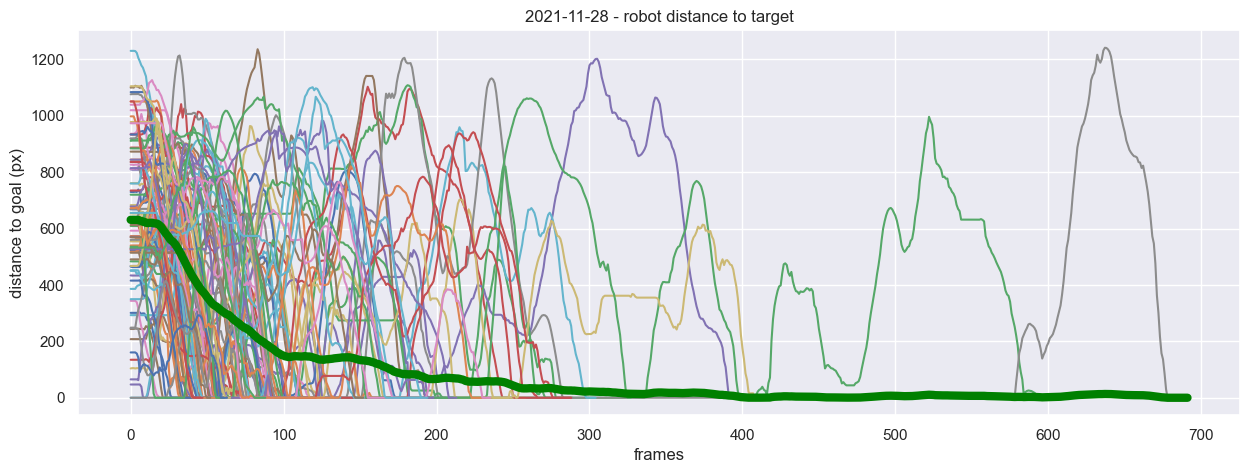

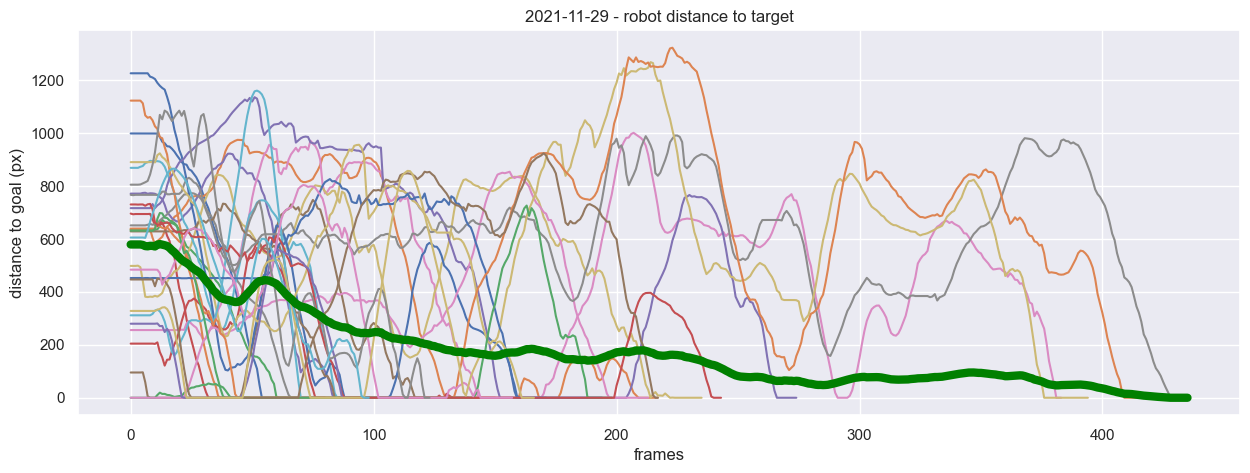

[<Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>,
 <Figure size 1500x500 with 1 Axes>]

In [4]:
# plot robot distance to goal over time
%matplotlib inline
plot_robot_distance_goal(dates_dict, start_date=None, end_date=None, challenges=True, only_successful=True)

### Plot following state **


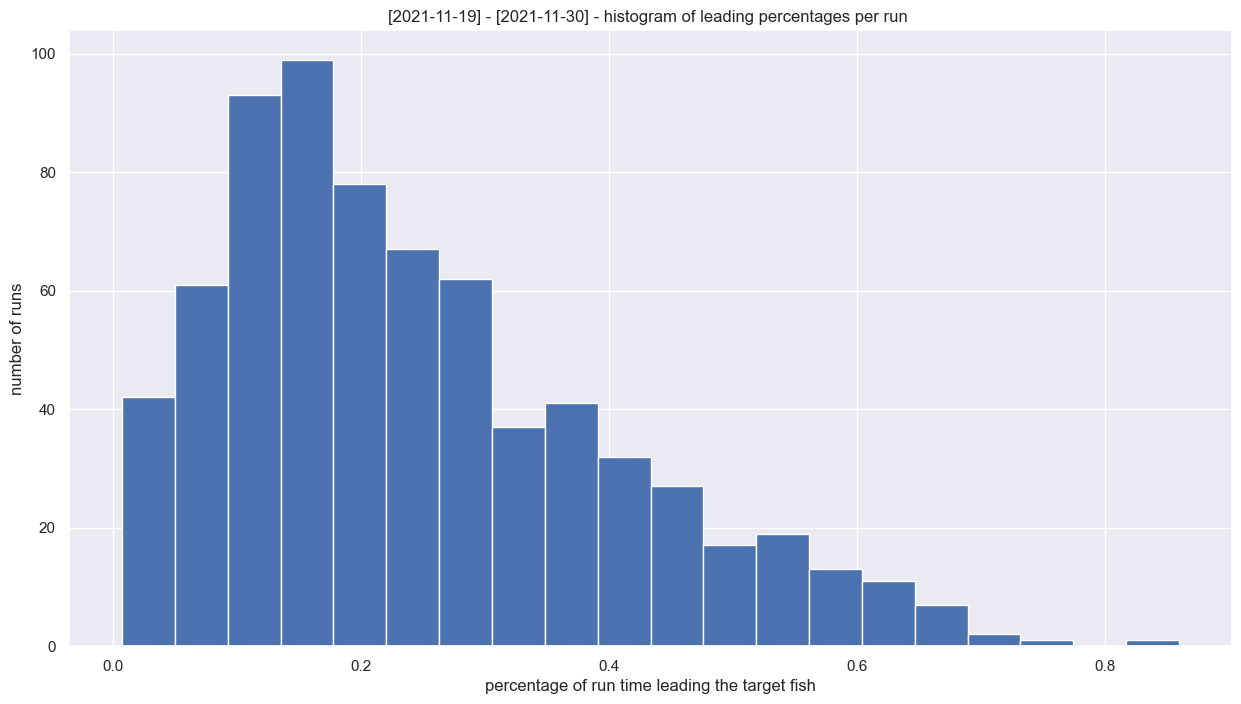

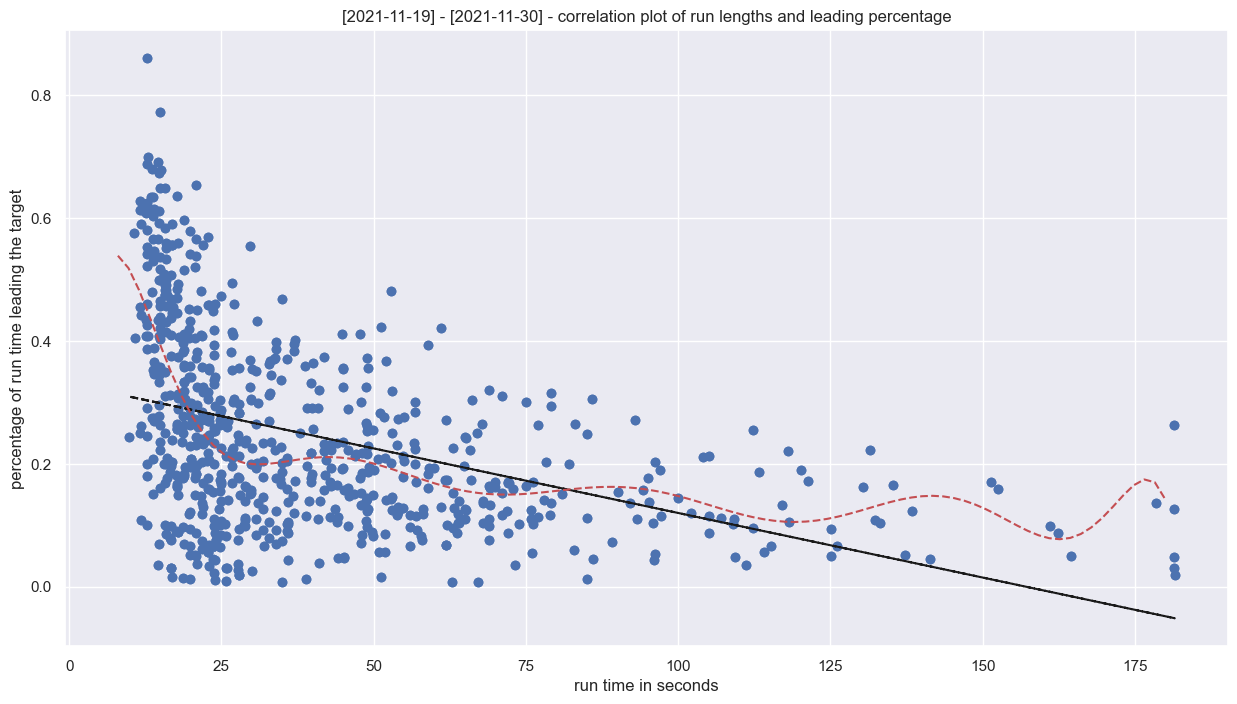

In [5]:
from plot import plot_following1
# plot histogram of leading percentages and correlation plot of run length and leading percentage
plot_following1(dates_dict, start_date=start_date, end_date=end_date, only_successful=True, challenges=True) 

### Plot run length and initial target (fish and zone) dist correlation

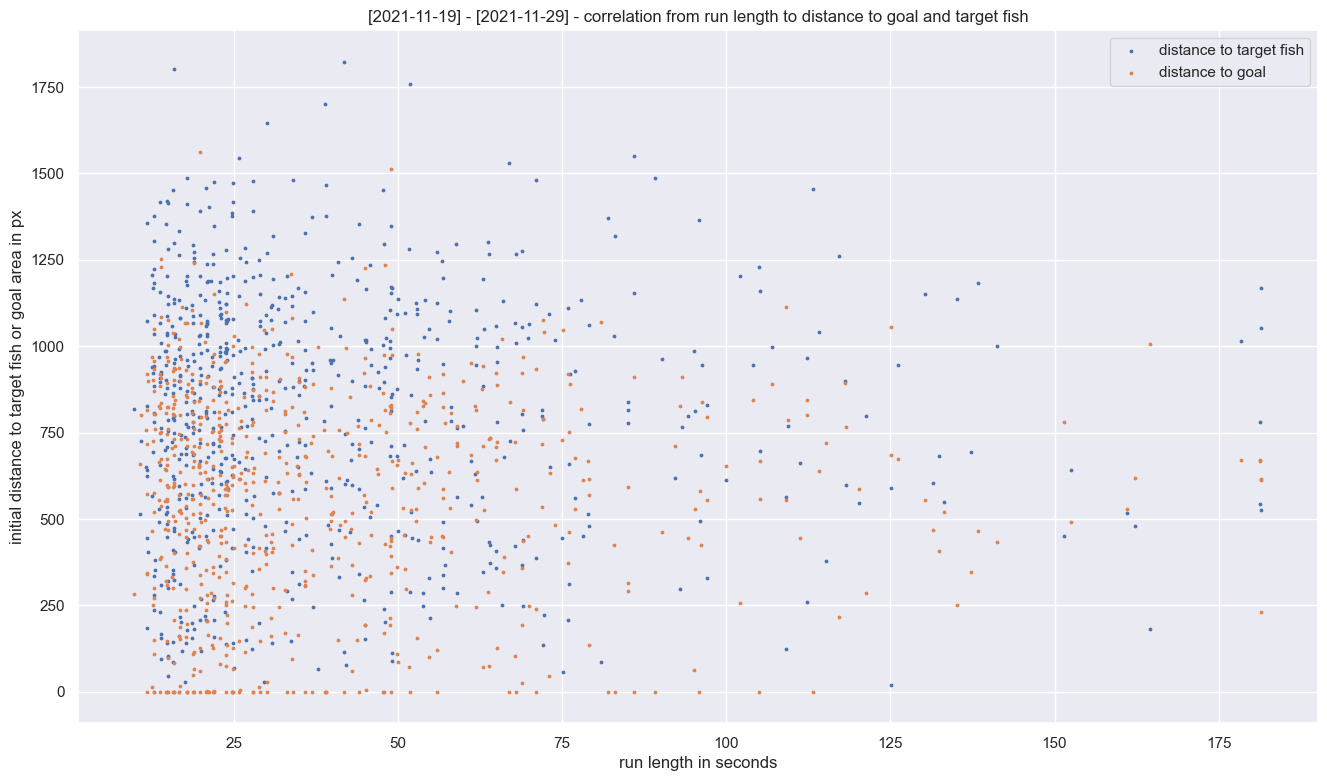

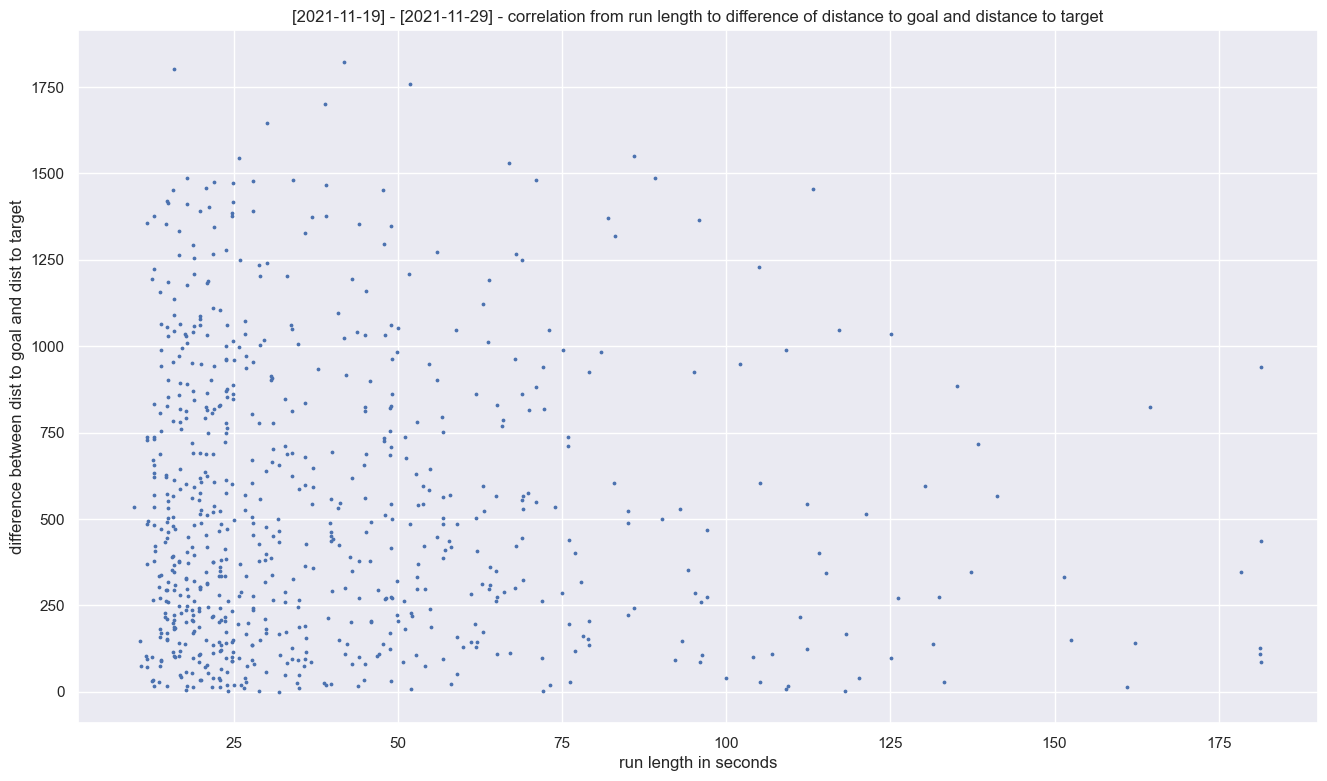

(<Figure size 1600x900 with 1 Axes>, <Figure size 1600x900 with 1 Axes>)

In [6]:
plot_runlength_dist_goal_target_corr(dates_dict, start_date=None, end_date=None, only_successful=True, challenges=True, show=True)

### Plot dist to goal(x) and dist to target(y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(107458,)


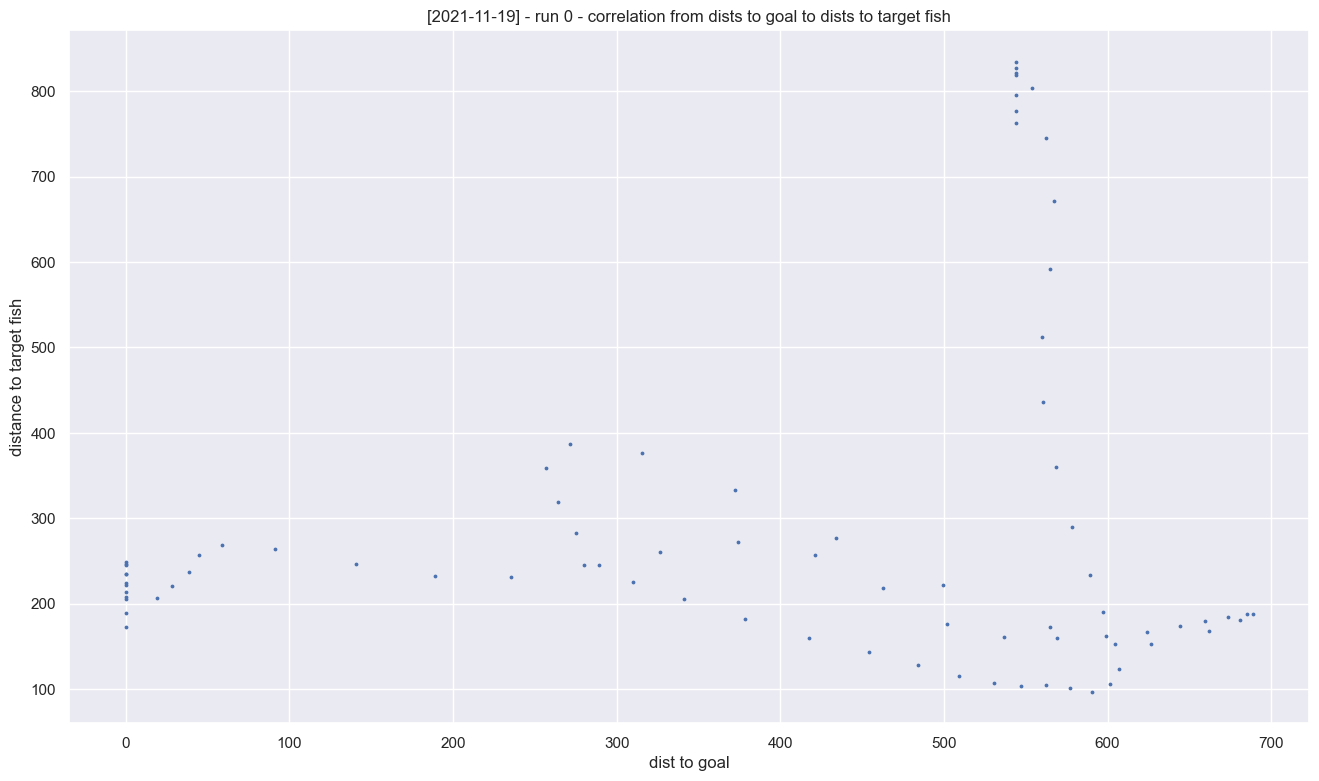

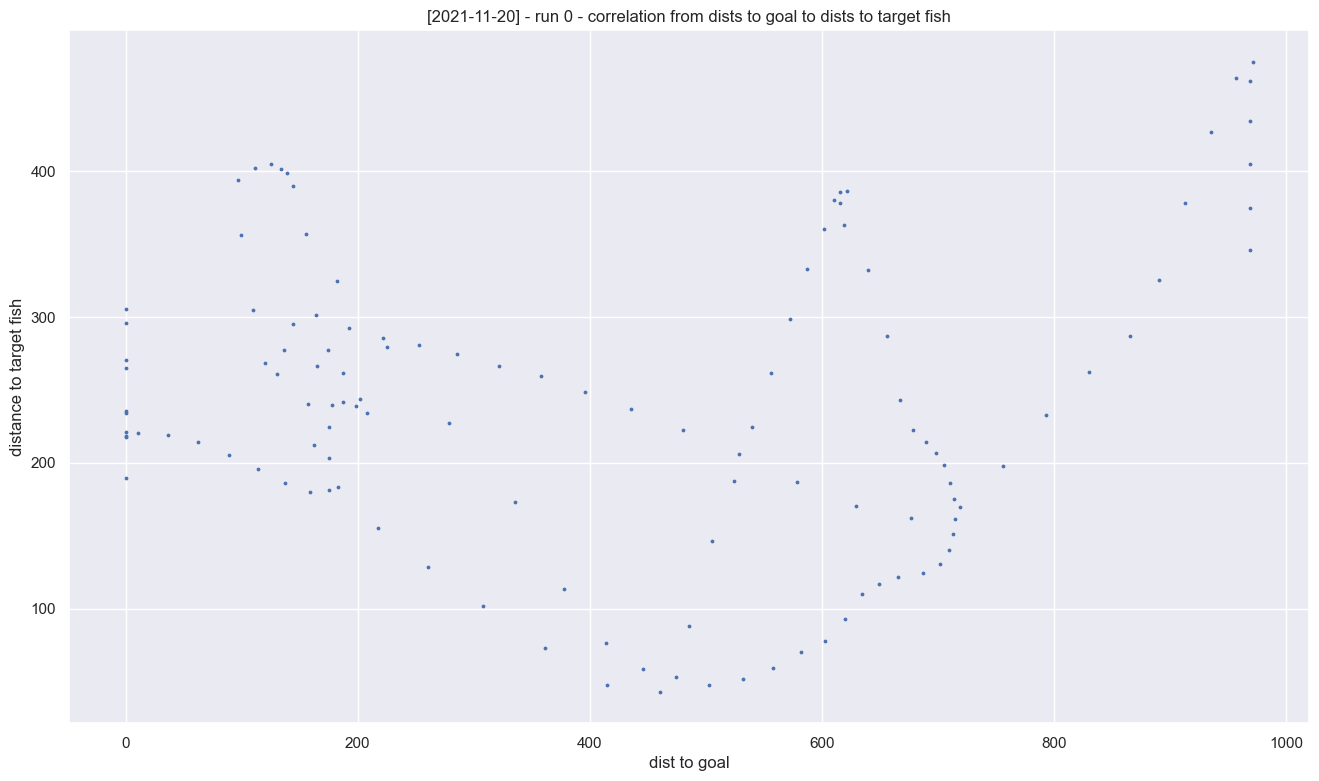

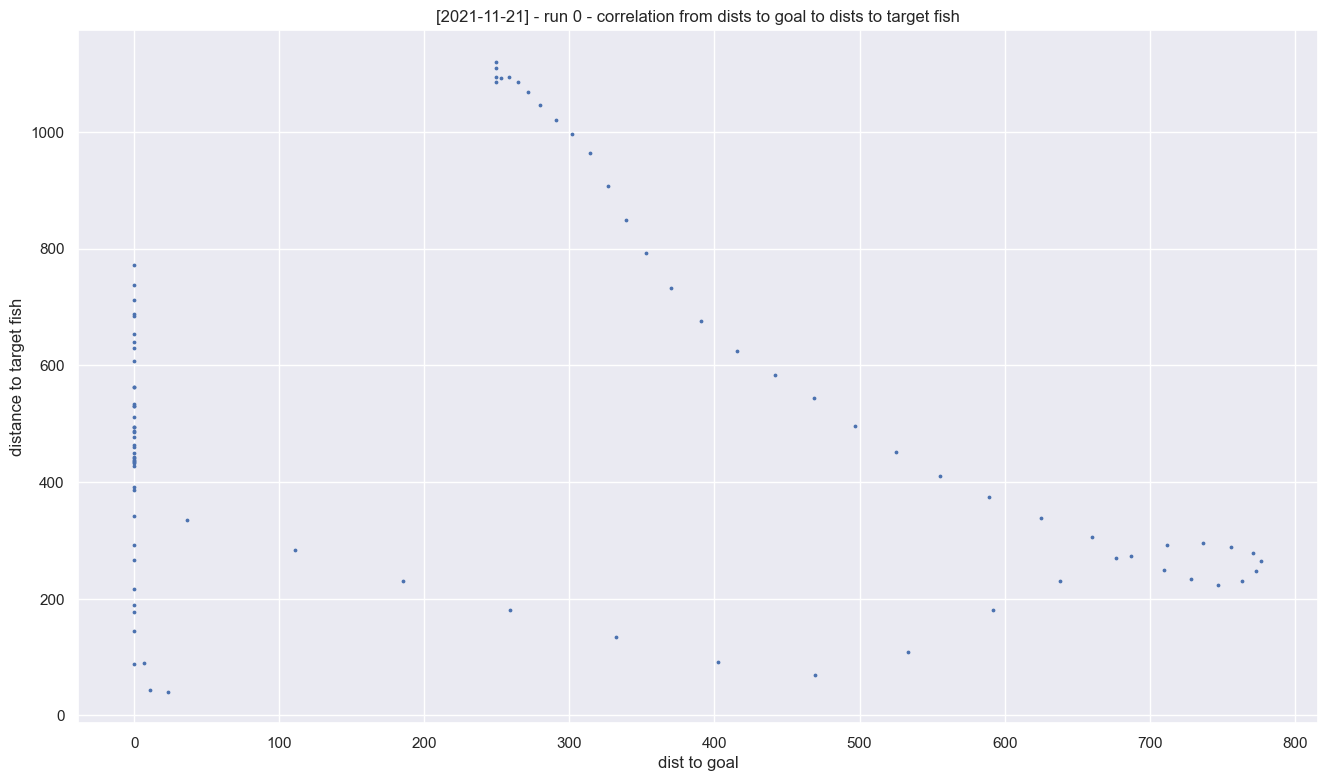

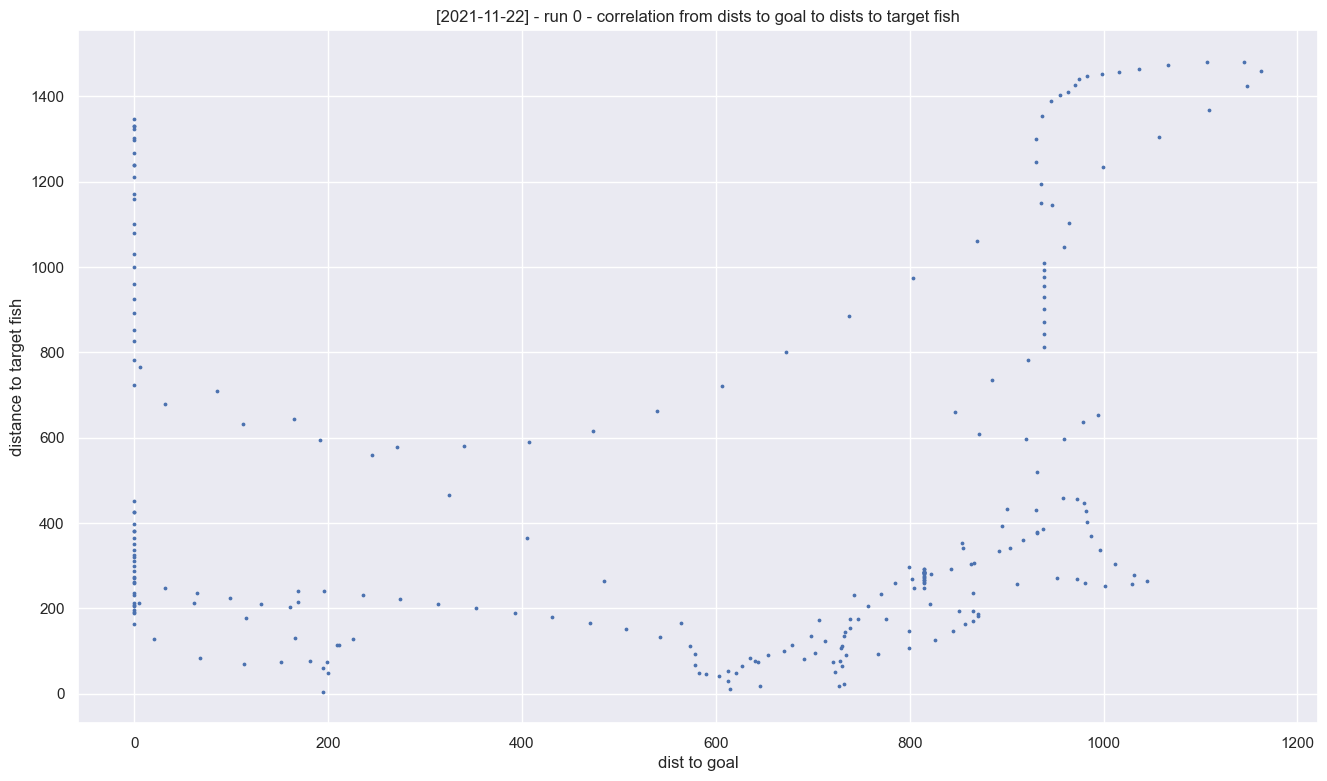

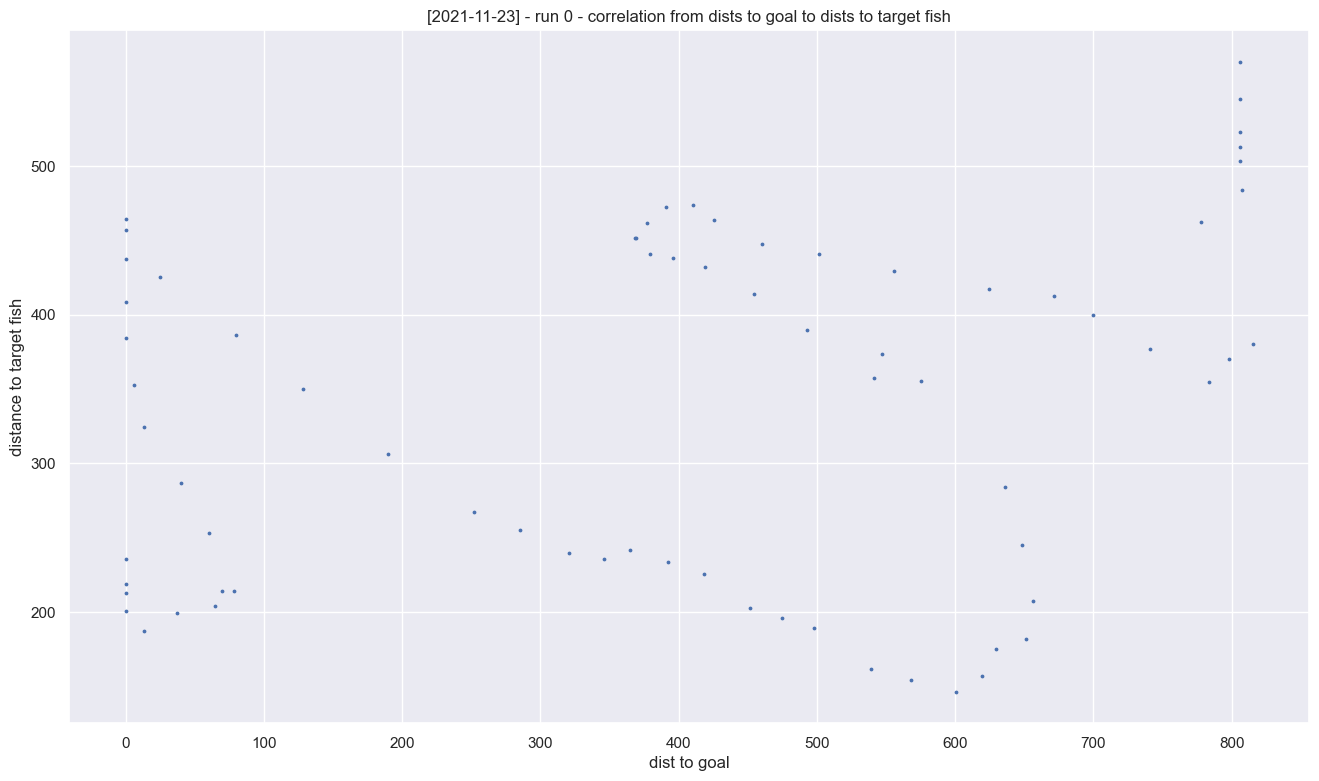

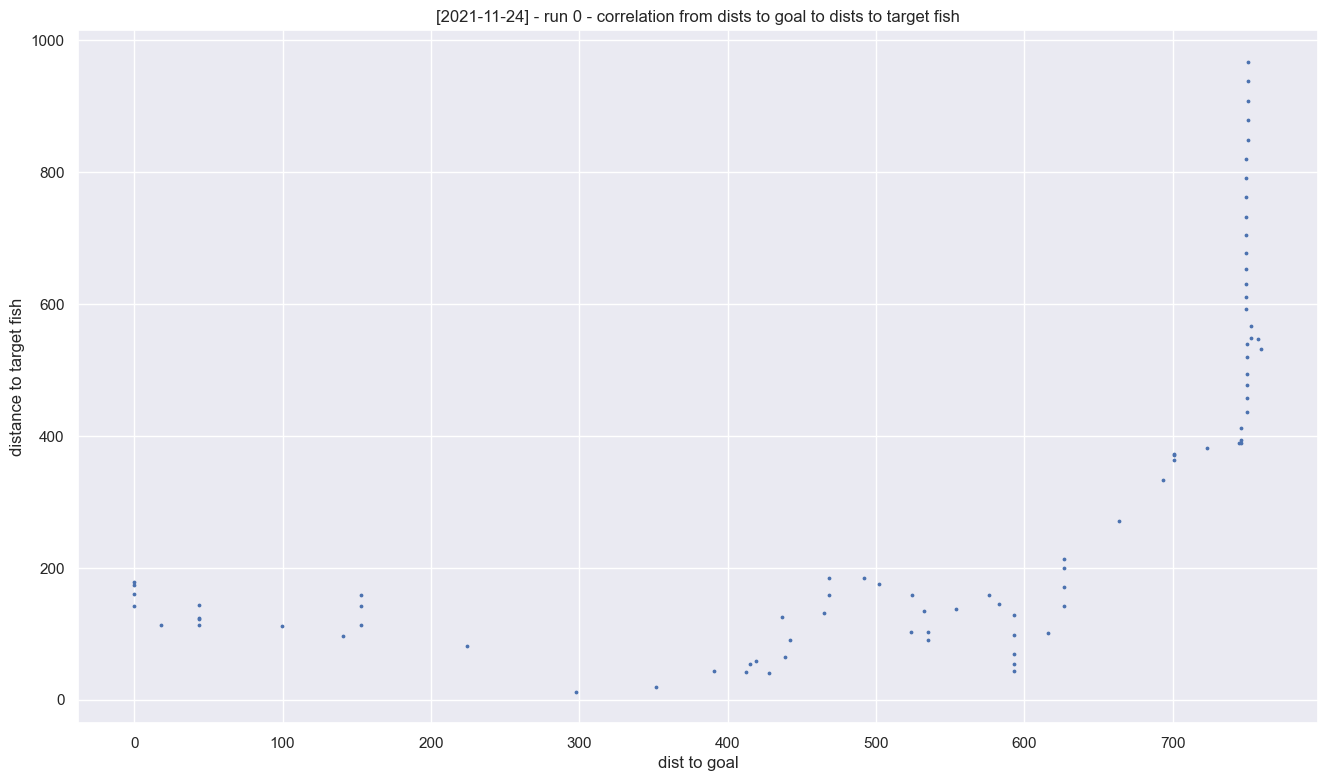

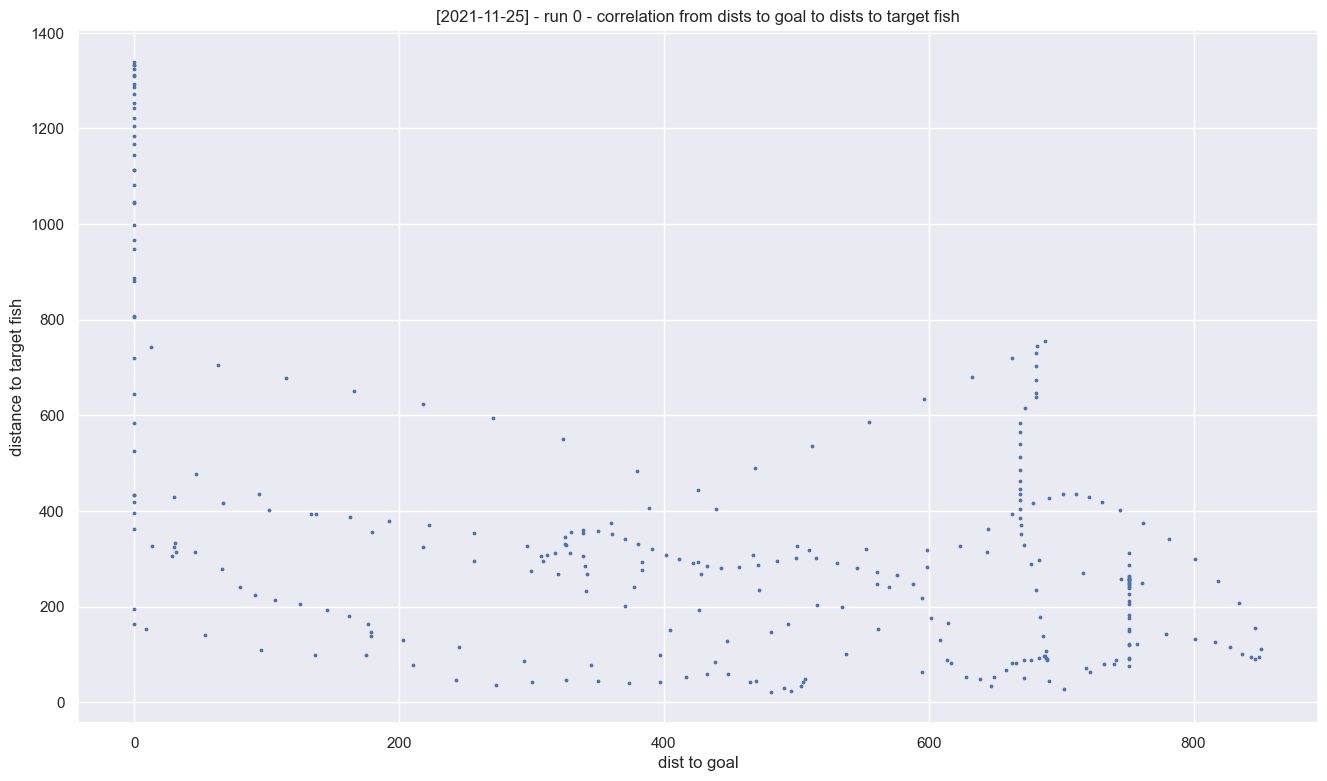

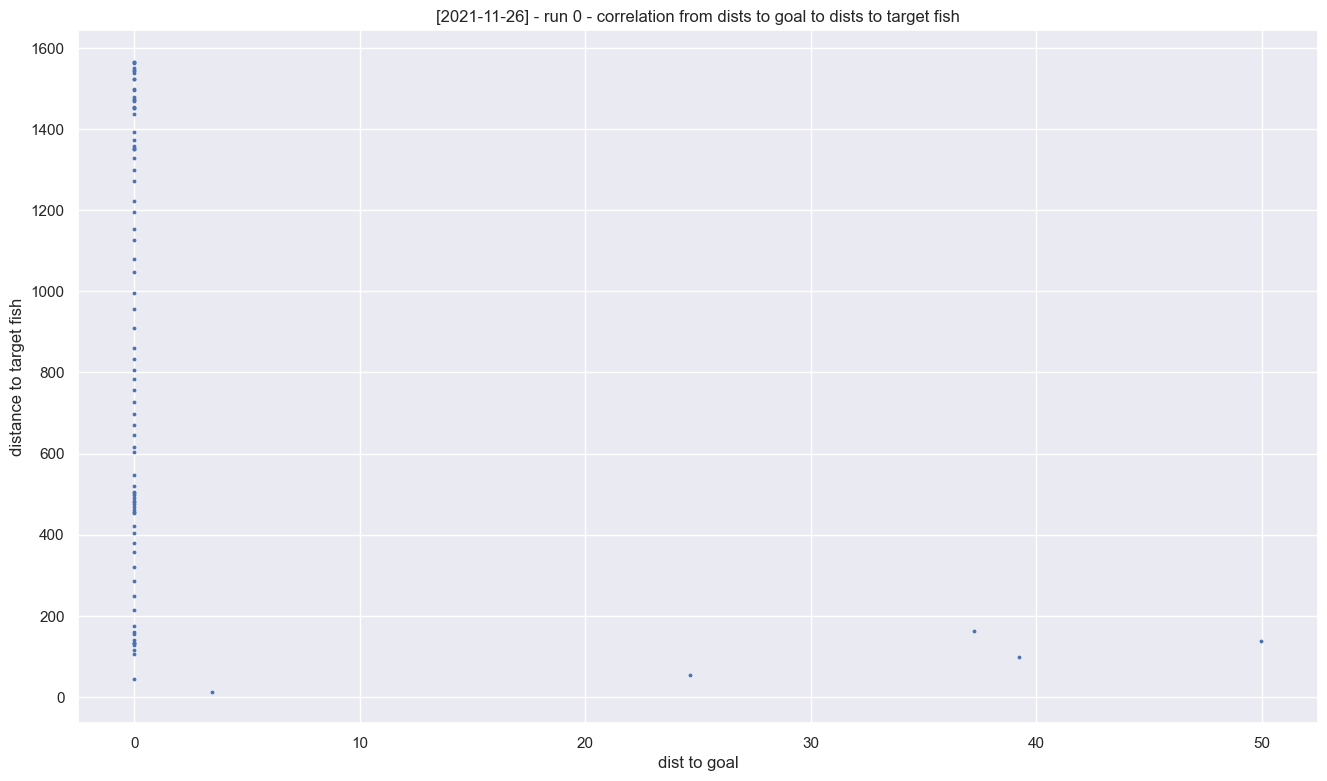

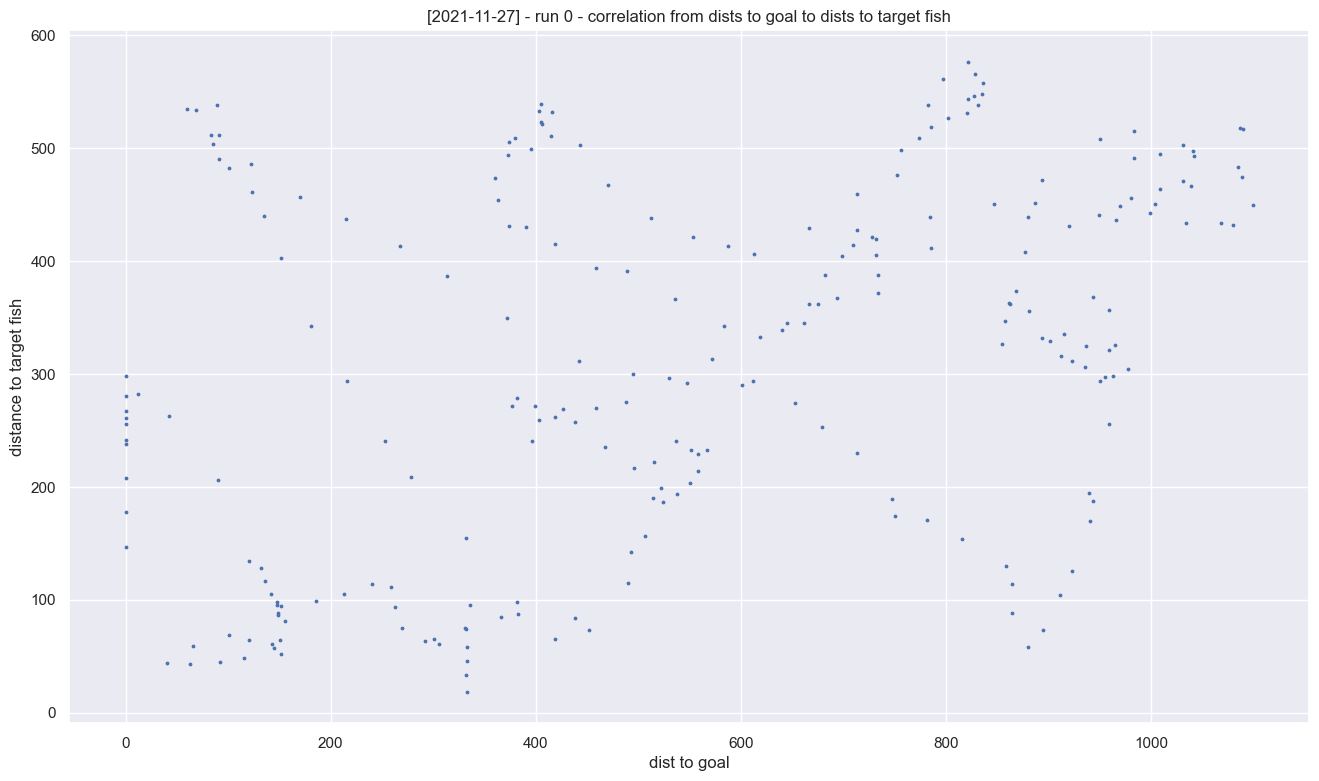

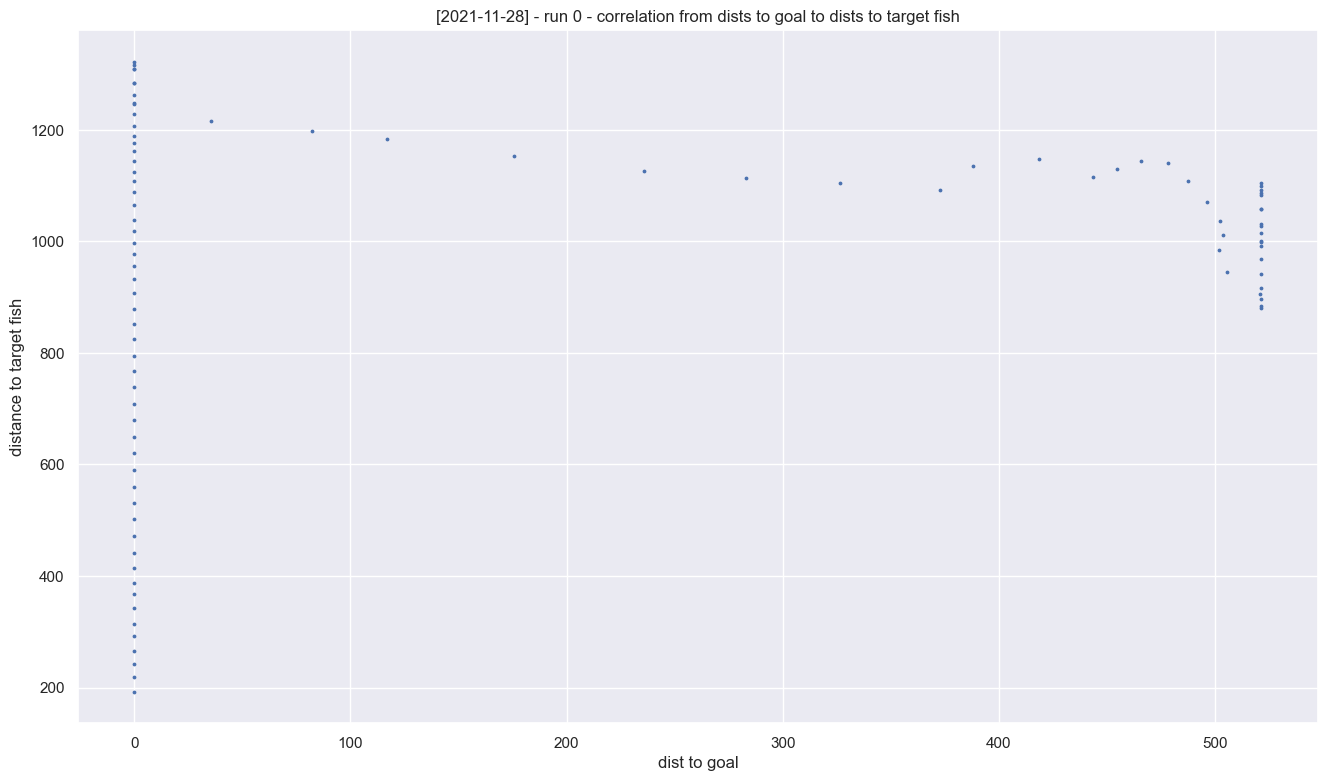

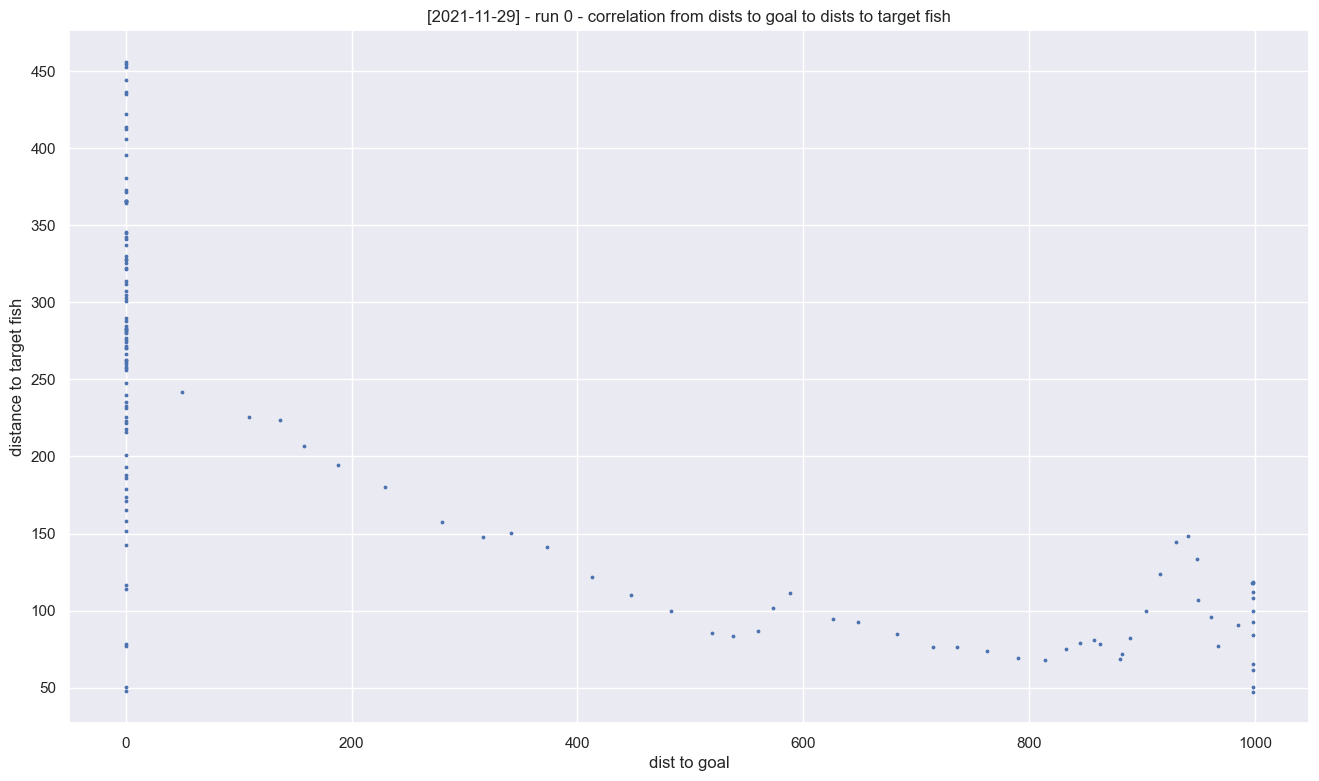

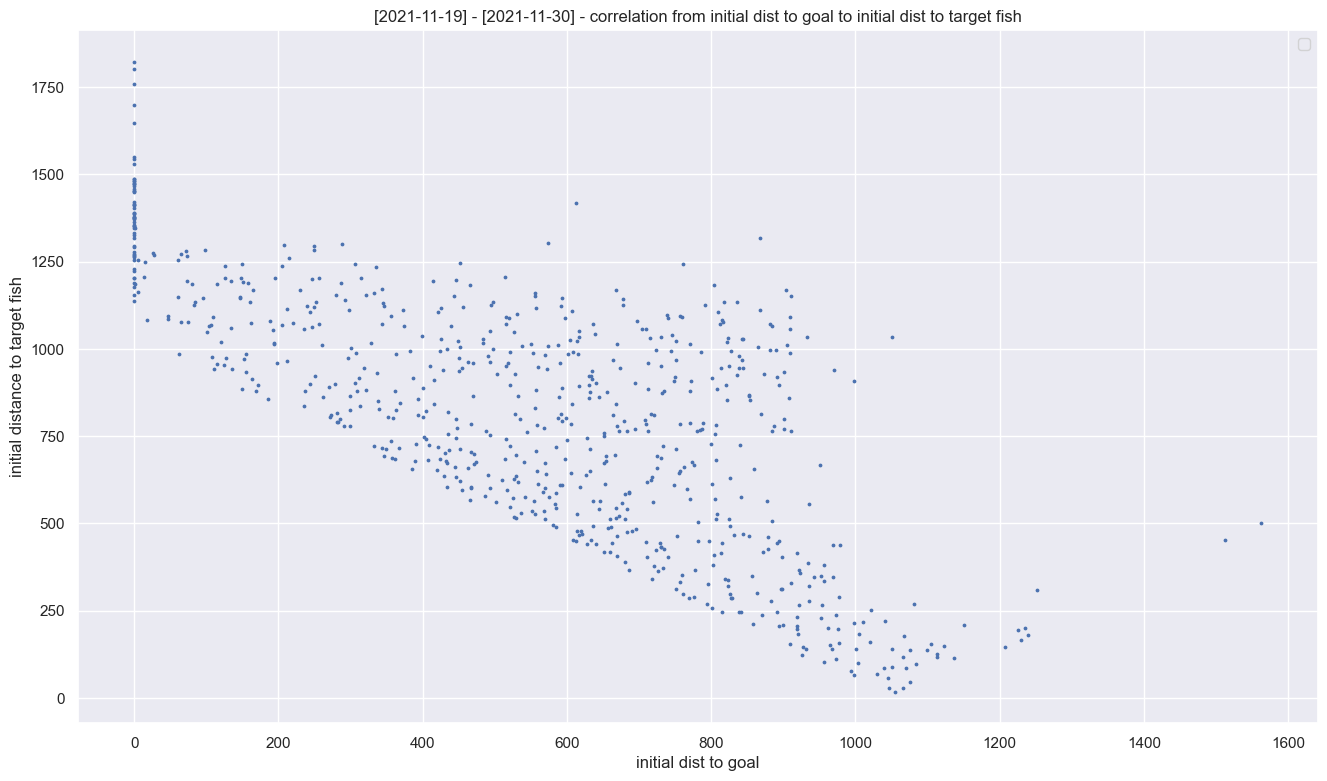

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


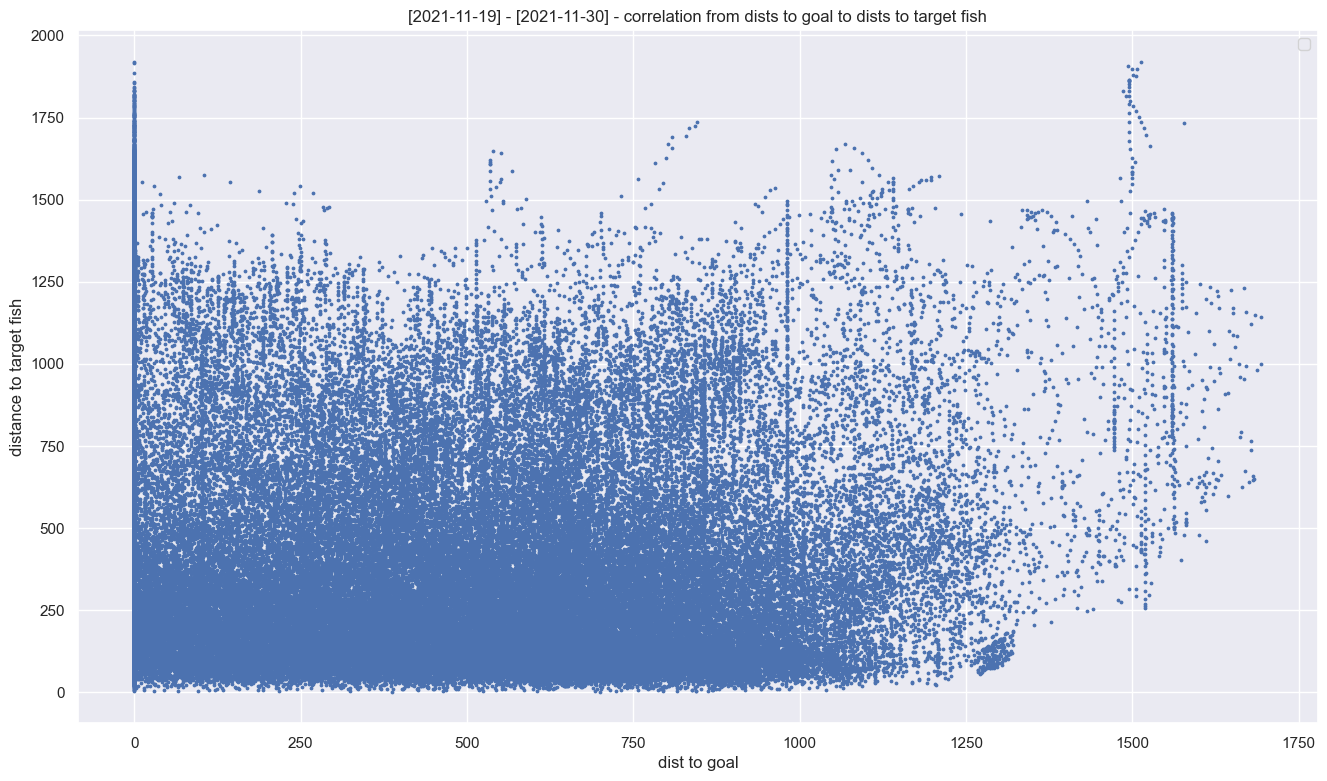

In [50]:
only_successful = True


dates_keys = dates_dict.keys()

if start_date is not None:
        start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
if end_date is not None:
        end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

daily_initial_dist_robot_target_fish = []
daily_initial_dist_robot_goal = []
daily_all_dist_robot_target_fish = []
daily_all_dist_robot_goal = []
for date_key in dates_keys:

     # filter date range
    date = datetime.strptime(date_key, '%Y-%m-%d')
    if start_date is not None:
        start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
        if start_date is not None and start_date_dt > date:
            continue
    else:
        start_date = list(dates_keys)[0]
    if end_date is not None:
        end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
        if end_date is not None and end_date_dt < date:
            continue
    else:
        end_date = list(dates_keys)[-1]
    
    # generate data for plots
    date_dict = dates_dict[date_key]

    fish_instance = date_dict["fish"]
    runs = date_dict["runs"]

    # filter runs
    if only_successful:
        runs, ids_runs = get_successful_runs(runs,date_dict["successful"])
    elif challenges:
        runs, ids_runs = get_challenge_runs(runs,date_dict["challenges"])
    else:
        runs = date_dict["runs"]
        ids_runs = list(range(len(runs)))


    # get pos for all fish for all timesteps
    if len(runs) > 0:
        fish_pos_runs = get_fish_pos_per_run(fish_instance,runs)
    else:
        print(f"No runs in {date_key}")
        continue
    
    day_all_dist_robot_target_fish = []
    day_all_dist_robot_goal = []
    day_initial_dist_robot_target_fish = []
    day_initial_dist_robot_goal = []
    for id_run, run in enumerate(runs):

        # get dist to target fish
        all_fish_pos_this_run = fish_pos_runs[id_run]       
        fish1_pos_this_run = np.array([fish[0] for fish in all_fish_pos_this_run])
        robot_pos_run = np.array(date_dict['positions'][run[0]:run[1]+1])
        assert len(fish1_pos_this_run) == len(robot_pos_run), print(f"fish:{len(fish1_pos_this_run)}; robot:{len(robot_pos_run)}")
        initial_distance = distance(fish1_pos_this_run[0], robot_pos_run[0])
        day_initial_dist_robot_target_fish.append(initial_distance)

        # sanity check
        if len(all_fish_pos_this_run) != len(robot_pos_run):
            print(f"Wrong array lengths: fish and robot {run} {len(all_fish_pos_this_run)} {len(robot_pos_run)}")
            assert False
        # else:
        #     print("all good") 

        # get dist to goal
        inital_robot_pos_run = robot_pos_run[0]
        initial_dist_goal = get_distance_to_goal(inital_robot_pos_run)

        day_initial_dist_robot_goal.append(initial_dist_goal)
        
        # calc dist of all pos to target and goal
        all_goal_dists = get_distance_to_goal(robot_pos_run)
        all_target_dists = np.linalg.norm(np.array(fish1_pos_this_run)-np.array(robot_pos_run), axis=1)
        assert len(all_goal_dists) == len(all_target_dists)
        
        day_all_dist_robot_goal.extend(all_goal_dists)
        day_all_dist_robot_target_fish.extend(all_target_dists)
        
        if id_run == 0:
            fig3 = plt.figure(figsize=(16,9))
            plt.scatter(all_goal_dists, all_target_dists, s=3)
            plt.xlabel("dist to goal")
            plt.ylabel("distance to target fish")
            plt.title(f"[{date_key}] - run {id_run} - correlation from dists to goal to dists to target fish")

    daily_initial_dist_robot_target_fish.append(day_initial_dist_robot_target_fish)
    daily_initial_dist_robot_goal.append(day_initial_dist_robot_goal)
    
    daily_all_dist_robot_target_fish.extend(day_all_dist_robot_target_fish)
    daily_all_dist_robot_goal.extend(day_all_dist_robot_goal)
    
flat_daily_initial_dist_robot_goal = flatten_2d_list(daily_initial_dist_robot_goal)
flat_daily_initial_dist_robot_target_fish = flatten_2d_list(daily_initial_dist_robot_target_fish)

print(np.asarray(daily_all_dist_robot_target_fish).shape)
    
# plot1
fig1 = plt.figure(figsize=(16,9))
plt.scatter(flat_daily_initial_dist_robot_goal, flat_daily_initial_dist_robot_target_fish, s=3)
plt.xlabel("initial dist to goal")
plt.ylabel("initial distance to target fish")
plt.title(f"[{start_date}] - [{end_date}] - correlation from initial dist to goal to initial dist to target fish")
plt.legend()
plt.show()

#plot2
fig2 = plt.figure(figsize=(16,9))
plt.scatter(daily_all_dist_robot_goal, daily_all_dist_robot_target_fish, s=3)
plt.xlabel("dist to goal")
plt.ylabel("distance to target fish")
plt.title(f"[{start_date}] - [{end_date}] - correlation from dists to goal to dists to target fish")
plt.legend()
plt.show()

### Histogram x distance to target and y turns towards target

### Plot start positions of target fish

In [ ]:
%matplotlib inline
only_successful = True
challenges = True

dates_keys = dates_dict.keys()

if start_date is not None:
        start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
if end_date is not None:
        end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

        
all_initial_fish_pos = []
for date_key in dates_keys:

    # check date 
    date = datetime.strptime(date_key, '%Y-%m-%d')
    if start_date is not None and start_date_dt > date:
        continue
    if end_date is not None and end_date_dt < date:
        continue

    # generate data for plots
    day_initial_fish_pos = []
    date_dict = dates_dict[date_key]

    fish_instance = date_dict["fish"]
    runs = date_dict["runs"]
    if only_successful:
        runs, _ = get_successful_runs(runs,date_dict["successful"])
    elif challenges:
        runs, _ = get_challenge_runs(runs,date_dict["challenges"])
    else:
        runs = date_dict["runs"]

    if len(runs) > 0:
        fish_pos_runs = get_fish_pos_per_run(fish_instance,runs)
    else:
        continue

    for id_run, run in enumerate(runs):
        fish_pos_this_run = fish_pos_runs[id_run]
        robot_pos_run = np.array(date_dict['positions'][run[0]:run[1]])
        # sanity check
        if len(fish_pos_this_run) != len(robot_pos_run):
            print("Wrong array lengths: fish and robot")
            assert False
        fish1_pos_this_run = np.array([fish[0] for fish in fish_pos_this_run])
        
        day_initial_fish_pos.append(fish1_pos_this_run[0])
    all_initial_fish_pos.append(day_initial_fish_pos)
flat_all_initial_fish_pos = []
for day_initial_fish_pos in all_initial_fish_pos:
    for initial_fish_pos in day_initial_fish_pos:
        flat_all_initial_fish_pos.append(initial_fish_pos)
flat_all_initial_fish_pos = np.asarray(flat_all_initial_fish_pos)

# print(flat_all_initial_fish_pos.shape)

fig = plt.figure(figsize=(15,9))
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.scatter(flat_all_initial_fish_pos[:,0], flat_all_initial_fish_pos[:,1])
plt.show()

### Plot usage statistics

In [ ]:
%matplotlib inline
# bar plot average time of day for each run
fig = plot_time_of_day_histogram(dates_dict, challenges=False, only_successful=True)

In [ ]:
%matplotlib inline
# bar plot number of (unique) visitors for each day
fig = plot_daily_number_runs(dates_dict, show=True)
fig.savefig("num_runs.png")

In [ ]:
%matplotlib inline
# plot daily use times and operational times in hours
fig = plot_daily_use_times_and_operational_times(dates_dict, to_pdf=False)

In [ ]:
# plot daily start and end times
%matplotlib inline
plot_daily_start_end_times(dates_dict)

In [ ]:
fig = plot_weekday_business(dates_dict, show=True)

### overall weekday business plot

In [ ]:
from util import daterange

use_only_challenge_data = True
        
#load days one by one and collect overall stats
start_date = datetime.strptime("2021-11-19", "%Y-%m-%d")
end_date = datetime.strptime("2022-10-25", "%Y-%m-%d")

weekday_perc_use_times = [[] for i in range(7)] #setup weekday array; 0 is monday
weekday_visitors = [[] for i in range(7)]
for single_date in daterange(start_date, end_date):
    current_date_str = single_date.strftime("%Y-%m-%d")
    # load day
    dates_dict = load_dates_from_npz(current_date_str, current_date_str, only_challenges=False, verbose=False)
    # extend day data
    dates_dict = extend_robot_data(dates_dict)
    # generate stats
    date_dict = dates_dict.get(current_date_str,{})
    if date_dict:
        date_ts = date_dict["timestamps"]
        date_run_lengths = date_dict["run_lengths"]
        date_runs = date_dict["runs"]

        # percentual use time
        day_length = date_dict.get("day_length",0)/60/60
        day_use_time = np.sum(date_run_lengths)/60/60
        perc_use_time = np.divide(day_use_time, day_length,out=np.zeros_like(day_use_time), where=day_length!=0) * 100

        # estimated num of visitors
        estimated_num_visitors = len(date_dict['runs']) - len(get_challenge_runs(date_runs,date_dict["challenges"])[0])

        # get current weekday 
        date_weekday = datetime.strptime(current_date_str+" 01:00:00,000", '%Y-%m-%d %H:%M:%S,%f').weekday()

        # fill weekday arrays
        weekday_perc_use_times[date_weekday].append(perc_use_time)
        weekday_visitors[date_weekday].append(estimated_num_visitors)
        
    else:
        # fill weekday arrays
        weekday_perc_use_times[date_weekday].append(0)
        weekday_visitors[date_weekday].append(0)
        
# get means
mean_weekday_perc_use_times = []
for weekday in weekday_perc_use_times:
    if len(weekday) == 0:
        mean_weekday_perc_use_times.append(0)
    else:
        mean_weekday_perc_use_times.append(np.nanmean(weekday))
# mean_weekday_perc_use_times = np.mean(weekday_perc_use_times, axis=1)
mean_weekday_visitors = []
for weekday in weekday_visitors:
    if len(weekday) == 0:
        mean_weekday_visitors.append(0)
    else:
        mean_weekday_visitors.append(np.nanmean(weekday))
        
        
# plot
with sns.axes_style("darkgrid"):
    # plot
    title = f"average weekday use times and visitors \n{start_date} - {end_date}"
    fig, ax1 = plt.subplots(num=title, figsize=(13,7))

    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    ax2 = ax1.twinx()
    num_vis_plot = ax1.bar(weekdays, mean_weekday_visitors, color='g', label='mean number of estimated visitors per weekday')
    perc_plot = ax2.plot(mean_weekday_perc_use_times, 'bo', ms=10, label='mean percentual use time of operational time')

    import matplotlib.ticker as mtick
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())


    ax1.set_xlabel('weekdays')
    ax1.set_ylabel('number of estimated visitors', color='g')
    ax2.set_ylabel('percentual use time of running time (in %)', color='b')

    print(ax1,ax2)
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})
    # nticks = 7
    # import matplotlib
    # ax1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    # ax2.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax1.grid(None)
    ax2.grid(None)
    # ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))

    ax1.legend(handles=[num_vis_plot,perc_plot[0]])

    
    plt.show()
    fig.savefig("overall_weekday_business.png")


# Filter challenge data

In [ ]:
# remove all non challenge data from dates_dict
filter_dates_dict_for_challenge_runs(dates_dict)

# Save data

### npy

In [ ]:
# save all loaded dates zo npz
save_dates_to_npz(dates_dict, only_challenges=True)

### compressed npz

In [ ]:
# save to gz file

for key in dates_dict.keys():
    date = dates_dict[key]
    file_name = f".\loaded_data\dates_dict_{key}_compressed.npz"
    print(f"Saving {key} to {file_name}")
    np.savez(file_name, date)

### json

In [ ]:
import json

# save day by day into json files
for key in dates_dict.keys():
    date = dates_dict[key]
    file_name = f".\loaded_data\dates_dict_{key}.json"
    print(f"Saving {key} to {file_name}")
    with open(file_name, 'w') as fp:
        json.dump(date, fp)


### hdf5

In [ ]:
import h5py
hf.close()
# save day by day into json files
for key in dates_dict.keys():
    date_dict = dates_dict[key]
    file_name = f".\loaded_data\dates_dict_{key}_compressed.h5"
    print(f"Saving {key} to {file_name}")
    hf = h5py.File(file_name, 'w')
    for dset_name in date_dict:
        #print(dset_name)
        if dset_name == 'fish':
            all_fish_grp = hf.create_group('fish')
            for ts, fish_ts in enumerate(date_dict['fish']):
                ts_grp = all_fish_grp.create_group(str(ts))
                for i, fish in enumerate(fish_ts):
                    fish_grp = ts_grp.create_group(str(i))
                    for dset_name_fish in fish:
                        try:
                            fish_grp.create_dataset(dset_name_fish, data = fish[dset_name_fish])
                        except Exception as e:
                            print(dset_name_fish)
                            print(e)
                            raise
        elif dset_name == 'day_length':
            try:
                dset = hf.create_dataset(dset_name, data = date_dict[dset_name])
            except Exception as e:
                print(dset_name)
                print(e)
                raise
        else:
            try:
                dset = hf.create_dataset(dset_name, data = date_dict[dset_name], compression="gzip")
            except Exception as e:
                print(dset_name)
                print(e)
                raise
        #print(grp_name, dset_name, data_dict[grp_name][dset_name])
    hf.close()

## deta base

In [ ]:
import toml
from deta import Deta  # Import Deta


# read deta key from secrets
project_key = toml.load(".streamlit\secrets.toml")["deta_key"]

# Initialize with a Project Key
deta = Deta(project_key)

# This how to connect to or create a database.
#db = deta.Base("human_leadership_data")
test = deta.Base("test")

'''
put(
  data: typing.Union[dict, list, str, int, float, bool], 
  key: str = None,
  *,
  expire_in: int = None,
  expire_at: typing.Union[int, float, datetime.datetime] = None
)
'''
for date_key in dates_dict:
    print(date_key)
    test.put({"timestamps":dates_dict[date_key]["timestamps"]}, date_key)
    print(test.get(date_key).keys())


## deta drive

In [ ]:
# upload files
from deta import Deta  # Import Deta

# read deta key from secrets
project_key = toml.load(".streamlit\secrets.toml")["deta_key"]

# Initialize with a Project Key
deta = Deta(project_key)

# This how to connect to or create a database.
drive = deta.Drive("human_leadership_data_HF")
date_files = glob.glob(f".\loaded_data\challenges_dates_dict_*.npy")
for file in date_files:
    os.path.basename(file)
    print(f"Uploading {file}")
    drive.put(os.path.basename(file), path=file)

In [24]:
# load files
from deta import Deta
deta = Deta(toml.load(".streamlit\secrets.toml")["deta_key"])        # Initialize with a Project Key
drive = deta.Drive("human_leadership_data_HF")

all_files = drive.list(limit=1000)["names"] #https://docs.deta.sh/docs/drive/sdk#list


date_file = drive.get(all_files[0])
os.remove("local_temp_file.npy")

with open("local_temp_file.npy", "wb+") as f:
    for chunk in date_file.iter_chunks(4096):
        f.write(chunk)
    date_file.close()
loaded_dict = np.load("local_temp_file.npy",allow_pickle=True).item()
loaded_dict.keys()
#os.remove("local_temp_file.npy")

dict_keys(['timestamps', 'positions', 'orientation', 'rotation', 'runs', 'day_length', 'run_lengths', 'difficulties', 'fish', 'challenges', 'successful'])

In [3]:
# create images drive
from deta import Deta
deta = Deta(toml.load(".streamlit\secrets.toml")["deta_key"])        # Initialize with a Project Key
drive = deta.Drive("images_HF")
drive.put('hello.txt', 'Hello world')

'hello.txt'

# GUI

In [ ]:
LoadingGUI(base_dir="C:/Users/admin/repos/thesis/logs_16_03_22/")

# Testing

In [7]:
from util import equalize_arrays
a = [[1],[2,2],[3,3,3,3,3]]

equalize_arrays(a,0)
print(a)
np.mean(a,axis=0)

[[1, 0, 0, 0, 0], [2, 2, 0, 0, 0], [3, 3, 3, 3, 3]]


array([2.        , 1.66666667, 1.        , 1.        , 1.        ])

In [ ]:
a = list(range(100))
b = [[0,3],[10,14], [17,21]]

c=[]
for i in b:
    c.append(a[i[0]:i[1]+1])
c

In [ ]:
a=[1,2,3,4]
a[5:]

In [ ]:
dates_dict['2022-02-01'].keys()

In [ ]:
def filter_date_dict_for_challenge_runs(date_dict, challenge_runs, ids_challenge_runs):
    filtered_date_dict = dict()
    filtered_date_dict['timestamps'] = []
    filtered_date_dict['positions'] = []
    filtered_date_dict['orientation'] = []
    filtered_date_dict['rotation'] = []
    filtered_date_dict['runs'] = []
    filtered_date_dict['day_length'] = date_dict['day_length']
    filtered_date_dict['run_lengths'] = []
    filtered_date_dict['difficulties'] = []
    filtered_date_dict['fish'] = []
    filtered_date_dict['challenges'] = []
    filtered_date_dict['successful'] = []
    
    run_pointer = 0
    for challenge_tuple in zip(challenge_runs, ids_challenge_runs):
        filtered_date_dict['timestamps'].extend(date_dict['timestamps'][challenge_tuple[0][0]:challenge_tuple[0][1]])
        filtered_date_dict['positions'].extend(date_dict['positions'][challenge_tuple[0][0]:challenge_tuple[0][1]])
        filtered_date_dict['orientation'].extend(date_dict['orientation'][challenge_tuple[0][0]:challenge_tuple[0][1]])
        filtered_date_dict['rotation'].extend(date_dict['rotation'][challenge_tuple[0][0]:challenge_tuple[0][1]])
        filtered_date_dict['runs'].append([run_pointer, run_pointer + date_dict['runs'][challenge_tuple[1]][1] - date_dict['runs'][challenge_tuple[1]][0]])
        run_pointer = run_pointer + date_dict['runs'][challenge_tuple[1]][1] - date_dict['runs'][challenge_tuple[1]][0] + 1
        filtered_date_dict['run_lengths'].append(date_dict['run_lengths'][challenge_tuple[1]])
        filtered_date_dict['difficulties'].append(date_dict['difficulties'][challenge_tuple[1]])
        filtered_date_dict['fish'].extend(date_dict['fish'][challenge_tuple[0][0]:challenge_tuple[0][1]])
        filtered_date_dict['challenges'].append(date_dict['challenges'][challenge_tuple[1]])
        filtered_date_dict['successful'].append(date_dict['successful'][challenge_tuple[1]])
        

    
    return filtered_date_dict

def filter_dates_dict_for_challenge_runs(dates_dict):
    for date_dict_key in dates_dict:
        date_dict = dates_dict[date_dict_key]
        runs = date_dict['runs']
        challenges = date_dict['challenges']
        challenge_runs, ids_challenge_runs = get_challenge_runs(runs, challenges)

        filtered_date_dict = filter_date_dict_for_challenge_runs(date_dict, challenge_runs, ids_challenge_runs)
        #print(date_dict['successful'][0:10], filtered_date_dict['successful'][0:10])
        dates_dict[date_dict_key] = filtered_date_dict
    